# OFDM simulation using 64 QAM modulation
OFDM (Orthogonal frequency division multiplexing) is a multicarrier system that is applied in a wide range of wireless transmission systems, such as LTE, WiMAX and DVB-T and DAB. The fundamental concept of a multicarrier system is the division of a high-rate transmitted data stream into several low-rate narrow subcarriers. This way, several advantages are obtained:
- Since the symbol duration is inverse proportional to the symbol rate, each subcarrier has relatively long symbols. Long symbols are robust against multipath fading, as it occurs in wireless systems.
- When a carrier is in a deep fade due to frequency-selectivity of the channel (i.e. the received energy on this carrier is very low), only the data on this subcarrier is lost, instead of the whole stream.
- Multicarrier systems allow easy multi-user resource sharing by allocating different subcarriers to different users.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import requests
import scipy
from scipy.ndimage import gaussian_filter1d
import scipy.fftpack

## Define Functions

### Helper functions

In [2]:
def xor(a, b):
    # initialize result
    result = []
    # same, then XOR is 0, else 1
    for i in range(1, len(b)):
        if a[i] == b[i]:
            result.append('0')
        else:
            result.append('1')
    return ''.join(result)

def covturl(urls):
    resp = requests.get(urls, stream=True).raw
    imgg = np.asarray(bytearray(resp.read()), dtype="uint8")
    return imgg

def mod2div(divident, divisor):
    # Number of bits to be XORed at a time.
    pick = len(divisor)
    # Slicing the divident to appropriate
    # length for particular step
    tmp = divident[0 : pick]
    while pick < len(divident):
        if tmp[0] == '1':
            # replace the divident by the result
            # of XOR and pull 1 bit down
            tmp = xor(divisor, tmp) + divident[pick]
        else:
            # If the leftmost bit of the dividend (or the
            # part used in each step) is 0, the step cannot
            # use the regular divisor; we need to use an
            # all-0s divisor.
            tmp = xor('0'*pick, tmp) + divident[pick]

        # increment pick to move further
        pick += 1

    # For the last n bits, we have to carry it out
    # normally as increased value of pick will cause
    # Index Out of Bounds.
    if tmp[0] == '1':
        tmp = xor(divisor, tmp)
    else:
        tmp = xor('0'*pick, tmp)

    checkword = tmp
    return checkword

def encodeData(data, key):
    l_key = len(key)
    # Appends n-1 zeroes at end of data
    appended_data = data + '0'*(l_key-1)
    remainder = mod2div(appended_data, key)
    # Append remainder in the original data
    codeword = data + remainder
    return codeword

def decodeData(data, key):
    l_key = len(key)
    # Appends n-1 zeroes at end of data
    appended_data = data + '0'*(l_key-1)
    remainder = mod2div(appended_data, key)
    return remainder

def split(word):
    return [char for char in word]

def PS_FIXED(bits):
    return bits.reshape((-1,))

### Channel functions

In [3]:
def group_bits(bits, bits_per_group):
    bits_groups = []
    x = 0
    for i in range((len(bits)//bits_per_group)+1):
        bits_groups.append(bits[x:x+bits_per_group])
        x = x+bits_per_group
    bits_groups[-1] = np.zeros(bits_per_group, dtype = int)
    return bits_groups

def group_bits_zero_pad(bits, bits_per_group):
    num_groups = (len(bits) + bits_per_group - 1) // bits_per_group
    # Pad the bits list with zeros if needed
    bits += [0] * (num_groups * bits_per_group - len(bits))
    # Use a list comprehension to create the groups
    bits_groups = [bits[i:i + bits_per_group] for i in range(0, len(bits), bits_per_group)]
    return bits_groups

def S2P(bits_serial : np.ndarray, length : int, mu : int):
    return bits_serial.reshape(length, mu)

def P2S(bits_parallel : np.ndarray):
    return bits_parallel.reshape((-1,))

def Mapping(bits, mapping_table):
    return np.array([mapping_table[tuple(b)] for b in bits])

def Demapping(QAM, mapping_table):
    demapping_table = {v : k for k, v in mapping_table.items()}
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    # get back the real constellation point
    hardDecision = constellation[const_index]
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

def OFDM_symbol(QAM_payload, dataCarriers, pilotCarriers, pilotValue):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)


def addCP(OFDM_time, CP):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # add them to the beginning

def removeCP(signal, CP, K):
    return signal[CP:(CP+K)]

def channel(signal, channelResponse, snrdb):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-snrdb/10) # calculate noise power based on signal power and SNR
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)

    return Hest
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

def get_payload(equalized, dataCarriers):
    return equalized[dataCarriers]

def channelEstimate_FIXED(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    return Hest

def channel_V(signal, channelResponse, snrdb):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-snrdb/10) # calculate noise power based on signal power and SNR
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def SNR_return(num_snr):
    SNR_Array = np.arange(0,num_snr,0.05)
    bitsnr = bits_groups[10]
    ber = []
    for i in SNR_Array:
        bits_SP = S2P(bitsnr, len(dataCarriers), mu)
        QAM = Mapping(bits_SP, mapping_table)
        OFDM_data = OFDM_symbol(QAM, dataCarriers, pilotCarriers, pilotValue)
        OFDM_time = IDFT(OFDM_data)
        OFDM_withCP = addCP(OFDM_time, CP)
        OFDM_Tx = OFDM_withCP
        OFDM_Rx = channel_V(OFDM_withCP, channelResponse, i)
        OFDM_RX_noCP = OFDM_Rx[(CP):(CP+K)]
        OFDM_demod = DFT(OFDM_RX_noCP)
        Hest = channelEstimate_FIXED(OFDM_demod)
        equalized_Hest = equalize(OFDM_demod, Hest)
        QAM_est = get_payload(equalized_Hest, dataCarriers)
        PS_est, hardDecision = Demapping(QAM_est, mapping_table)
        bits_est = PS_FIXED(PS_est)
        ber.append(np.sum(abs(bitsnr-bits_est))/len(bitsnr))
    return SNR_Array, ber

def channel_X(signal):
    convolved = np.convolve(signal,channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRDB/10) # calculate noise power based on signal power and SNR
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

## Main

### Parameters setup

In [4]:
save_fig = False # To save plot during running

### Transmitter Part

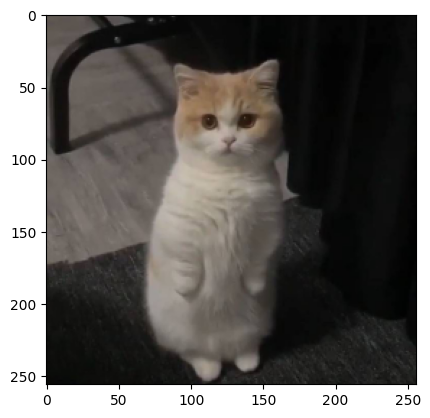

In [5]:
img = plt.imread("images/medium.bmp")
plt.imshow(img)
plt.savefig("results/input.png")
plt.show()

#### Data Pre-rocessing

First we get all the pixels value of the image and lay them in a 1D array. This array is gonna have a size of `width x height x channel`

In [6]:
pixels = img.reshape(img.shape[0]*img.shape[1]*img.shape[2])

The pixels value is in decimal, we need to convert it into binary

In [7]:
img_bytes = [format(pixel, "08b") for pixel in pixels]

Subsequently, we using the CRC (Cyclic redundancy check) to add the key 1101 to each byte

In [8]:
key = "1101"
img_en = [encodeData(i, key) for i in img_bytes]

In [9]:
img_bits = [[bit for bit in byte] for byte in np.array(img_en)]
img_bits = np.vstack(img_bits)
# img_ready_for_trans
img_bits_tx = np.array([int(i[j]) for i in img_bits for j in range(11)])

### Channel Part

In the following OFDM example, we will go through each block and describe its operation. However, before let us define some parameters that are used for the OFDM system:
- The number of subcarriers $K$ describes, how many subcarriers are available in the OFDM system.
- The length of the cyclic prefix (CP) denotes the number of samples that are copied from the end of the modulated block to the beginning, to yield a cyclic extension of the block.
- The number of pilots $P$ in the OFDM symbol describes, how many carriers are used to transmit known information (i.e. pilots). Pilots will be used at the receiver to estimate the wireless channel between transmitter and receiver. Further, we also define the value that each pilots transmits (which is known to the receiver).

allCarriers:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
pilotCarriers:
 [  0  16  32  48  64  80  96 112 127]
dataCarriers:
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 10

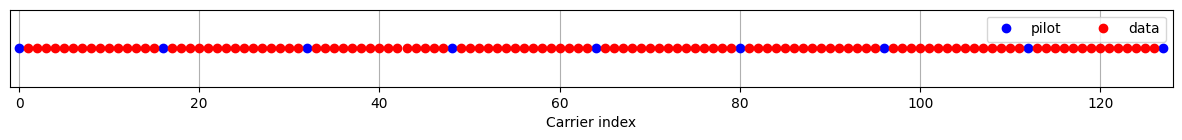

In [10]:
# CA
K = 128                                 # number of OFDM subcarriers
CP = K // 4                             # length of the cyclic prefix: 25% of the block
P = 8                                   # number of pilot carriers per OFDM block
SNRDB = 20                              # signal to noise-ratio in dB at the receiver
pilotValue = 7+7j                       # The known value each pilot transmits
allCarriers = np.arange(K)              # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P]     # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, the last carrier is also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
print ("allCarriers:\n", allCarriers)
print ("pilotCarriers:\n", pilotCarriers)
print ("dataCarriers:\n", dataCarriers)

plt.figure(figsize=(15,1))
plt.xlim((-1,K)); plt.ylim((-0.1, 0.1))
plt.xlabel('Carrier index')
plt.yticks([])
plt.grid(True)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.legend(fontsize=10, ncol=2)
if save_fig:
    plt.savefig("results/Carrier_index.png")
plt.show()

Let's define the modulation index $\mu$ and the corresponding mapping table. We consider 16QAM transmission, i.e. we have $\mu=6$ bits per symbol. Furthermore, the mapping from groups of 6 bits to a 64QAM constellation symbol shall be defined in `mapping_table`.

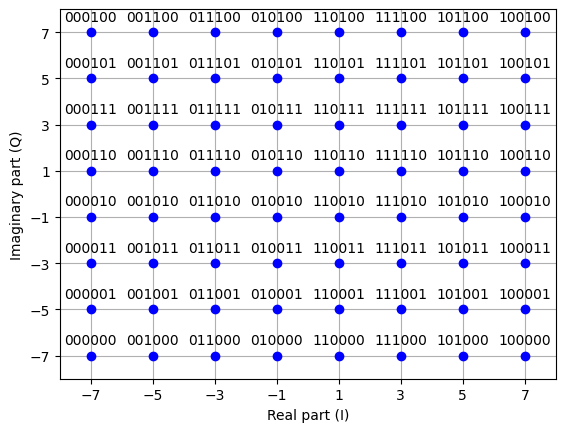

In [11]:
mu = 6 # bits per symbol (64QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0,0,0) : -7-7j,
    (0,0,0,0,0,1) : -7-5j,
    (0,0,0,0,1,1) : -7-3j,
    (0,0,0,0,1,0) : -7-1j,
    (0,0,0,1,1,0) : -7+1j,
    (0,0,0,1,1,1) : -7+3j,
    (0,0,0,1,0,1) : -7+5j,
    (0,0,0,1,0,0) : -7+7j,
    (0,0,1,1,0,0) : -5+7j,
    (0,0,1,1,0,1) : -5+5j,
    (0,0,1,1,1,1) : -5+3j,
    (0,0,1,1,1,0) : -5+1j,
    (0,0,1,0,1,0) : -5-1j,
    (0,0,1,0,1,1) : -5-3j,
    (0,0,1,0,0,1) : -5-5j,
    (0,0,1,0,0,0) : -5-7j,
    (0,1,1,0,0,0) : -3-7j,
    (0,1,1,0,0,1) : -3-5j,
    (0,1,1,0,1,1) : -3-3j,
    (0,1,1,0,1,0) : -3-1j,
    (0,1,1,1,1,0) : -3+1j,
    (0,1,1,1,1,1) : -3+3j,
    (0,1,1,1,0,1) : -3+5j,
    (0,1,1,1,0,0) : -3+7j,
    (0,1,0,1,0,0) : -1+7j,
    (0,1,0,1,0,1) : -1+5j,
    (0,1,0,1,1,1) : -1+3j,
    (0,1,0,1,1,0) : -1+1j,
    (0,1,0,0,1,0) : -1-1j,
    (0,1,0,0,1,1) : -1-3j,
    (0,1,0,0,0,1) : -1-5j,
    (0,1,0,0,0,0) : -1-7j,
    (1,1,0,0,0,0) : 1-7j,
    (1,1,0,0,0,1) : 1-5j,
    (1,1,0,0,1,1) : 1-3j,
    (1,1,0,0,1,0) : 1-1j,
    (1,1,0,1,1,0) : 1+1j,
    (1,1,0,1,1,1) : 1+3j,
    (1,1,0,1,0,1) : 1+5j,
    (1,1,0,1,0,0) : 1+7j,
    (1,1,1,1,0,0) : 3+7j,
    (1,1,1,1,0,1) : 3+5j,
    (1,1,1,1,1,1) : 3+3j,
    (1,1,1,1,1,0) : 3+1j,
    (1,1,1,0,1,0) : 3-1j,
    (1,1,1,0,1,1) : 3-3j,
    (1,1,1,0,0,1) : 3-5j,
    (1,1,1,0,0,0) : 3-7j,
    (1,0,1,0,0,0) : 5-7j,
    (1,0,1,0,0,1) : 5-5j,
    (1,0,1,0,1,1) : 5-3j,
    (1,0,1,0,1,0) : 5-1j,
    (1,0,1,1,1,0) : 5+1j,
    (1,0,1,1,1,1) : 5+3j,
    (1,0,1,1,0,1) : 5+5j,
    (1,0,1,1,0,0) : 5+7j,
    (1,0,0,1,0,0) : 7+7j,
    (1,0,0,1,0,1) : 7+5j,
    (1,0,0,1,1,1) : 7+3j,
    (1,0,0,1,1,0) : 7+1j,
    (1,0,0,0,1,0) : 7-1j,
    (1,0,0,0,1,1) : 7-3j,
    (1,0,0,0,0,1) : 7-5j,
    (1,0,0,0,0,0) : 7-7j,
}
for d5 in [0,1]:
    for d4 in [0,1]:
        for d3 in [0,1]:
            for d2 in [0,1]:
                for d1 in [0,1]:
                    for d0 in [0,1]:
                        D = (d5,d4,d3,d2,d1,d0)
                        Q = mapping_table[D]
                        plt.plot(Q.real,Q.imag, 'bo')
                        plt.text(Q.real,Q.imag+0.5, "".join(str(x) for x in D), ha = 'center')

# plt.title("Mapping Table 6 symbol")
plt.grid(True)
plt.xticks(range(-7,8,2))
plt.yticks(range(-7,8,2))
plt.xlim((-8, 8)); plt.ylim((-8,8))
plt.xlabel('Real part (I)')
plt.ylabel('Imaginary part (Q)')
if save_fig:
    plt.savefig("results/mapping.png")
plt.show()

We group the bits into a group of `payloadBits_per_OFDM`, which in this case, equals 714

In [12]:
bits_groups = group_bits(img_bits_tx, payloadBits_per_OFDM)

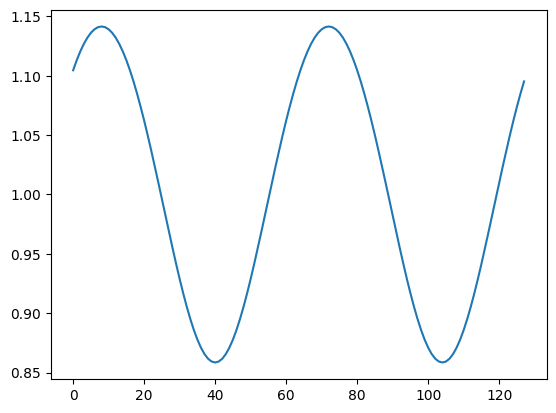

In [13]:
## in this part, we demonstate selecting only 1 frame to send. ##
demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1,0,0.1+0.1j]) # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))
if save_fig:
    plt.savefig("results/oneframe.png")
plt.show()

The `bits` are now sent to a serial-to-parallel converter, which groups the bits for the OFDM frame into a groups of $\mu$ bits (i.e. one group for each subcarrier):

In [14]:
# Serial/Parallel
bits = np.array(bits_groups[2]) # we select frame 2 to send
bits_SP = S2P(bits, len(dataCarriers), mu)
print ("First 5 bit groups:")
print (bits_SP[:5,:])

First 5 bit groups:
[[0 1 0 1 0 1]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [1 0 1 0 1 1]
 [0 1 0 1 1 1]]


Now, the bits groups are sent to the mapper. The mapper converts the groups into complex-valued constellation symbols according to the `mapping_table`.

In [15]:
QAM = Mapping(bits_SP, mapping_table)
print ("First 5 QAM symbols:")
print (QAM[:5])

First 5 QAM symbols:
[-1.+5.j -1.+5.j  5.-1.j  5.-3.j -1.+3.j]


The next step (which is not shown in the diagram) is the allocation of different subcarriers with data and pilots. For each subcarrier we have defined wether it carries data or a pilot by the arrays `dataCarriers` and `pilotCarriers`.

Next, to create the overall OFDM data, we need to put the data and pilots into the OFDM carriers.

Now, the OFDM carriers contained in `OFDM_data` can be transformed to the time-domain by means of the IDFT operation. 

Subsequently, we add a cyclic prefix to the symbol. This operation concatenates a copy of the last `CP` samples of the OFDM time domain signal to the beginning. This way, a cyclic extension is achieved. The CP fulfills two tasks:

1. It isolates different OFDM blocks from each other when the wireless channel contains multiple paths, i.e. is frequency-selective.
2. It turns the linear convolution with the channel into a circular one. Only with a circular convolution, we can use the single-tap equalization OFDM is so famous for.

In [16]:
OFDM_data = OFDM_symbol(QAM, dataCarriers, pilotCarriers, pilotValue)
OFDM_time = IDFT(OFDM_data)
OFDM_withCP = addCP(OFDM_time, CP)

print("Number of OFDM carriers in frequency domain:     ", len(OFDM_data))
print("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))
print("Number of OFDM samples in time domain with CP:   ", len(OFDM_withCP))

Number of OFDM carriers in frequency domain:      128
Number of OFDM samples in time-domain before CP:  128
Number of OFDM samples in time domain with CP:    160


Now, the signal is sent to the antenna and sent over the air to the receiver. In between both antennas, there is the wireless channel. We model this channel as a static multipath channel with impulse response `channelResponse`. Hence, the signal at the receive antenna is the convolution of the transmit signal with the channel response. Additionally, we add some noise to the signal according to the given SNR value:

RX Signal power: 0.4031. Noise power: 0.0040


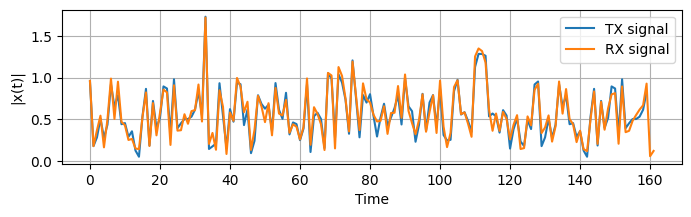

In [17]:
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX, channelResponse, SNRDB)

plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel("Time") 
plt.ylabel("|x(t)|")
plt.grid(True)
if save_fig:
    plt.savefig("results/tx_rx.png")
plt.show()

Now, at the receiver the CP is removed from the signal and a window of $K$ samples is extracted from the received signal.

Afterwards, the signal is transformed back to the frequency domain, in order to have the received value on each subcarrier available.

As the next step, the wireless channel needs to be estimated. For illustration purposes, we resort to a simple zero-forcing channel estimation followed by a simple interpolation. The principle of channel estimation is as follows:

The transmit signal contains pilot values at certain pilot carriers. These pilot values and their position in the frequency domain (i.e. the pilot carrier index) are known to the receiver. From the received information at the pilot subcarriers, the receiver can estimate the effect of the wireless channel onto this subcarrier (because it knows what was transmitted and what was received). Hence, the receiver gains information about the wireless channel at the pilot carriers. However, it wants to know what happened at the data carriers. To achieve this, it interpolates the channel values between the pilot carriers to get an estimate of the channel in the data carriers.

Now that the channel is estimated at all carriers, we can use this information in the channel equalizer step. Here, for each subcarrier, the influence of the channel is removed such that we get the clear (only noisy) constellation symbols back.

The next step (not shown in the diagram) is to extract the data carriers from the equalized symbol. Here, we throw away the pilot carriers, as they do not provide any information, but were used for the channel estimation process.

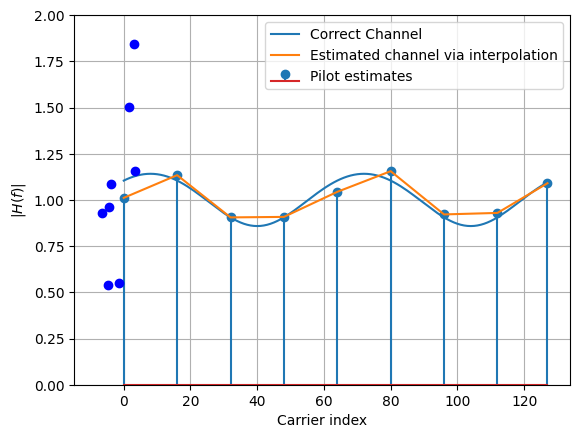

In [18]:
OFDM_RX_noCP = removeCP(OFDM_RX, CP, K)
OFDM_demod = DFT(OFDM_RX_noCP)
Hest = channelEstimate(OFDM_demod)
equalized_Hest = equalize(OFDM_demod, Hest)
QAM_est = get_payload(equalized_Hest, dataCarriers)
plt.plot(QAM_est.real, QAM_est.imag, 'bo', scalex = True, scaley = True)
if save_fig:
    plt.savefig("results/Estimated_channel.png")
plt.show()

Now, that the constellation is obtained back, we need to send the complex values to the demapper, to transform the constellation points to the bit groups. In order to do this, we compare each received constellation point against each possible constellation point and choose the constellation point which is closest to the received point. Then, we return the bit-group that belongs to this point.

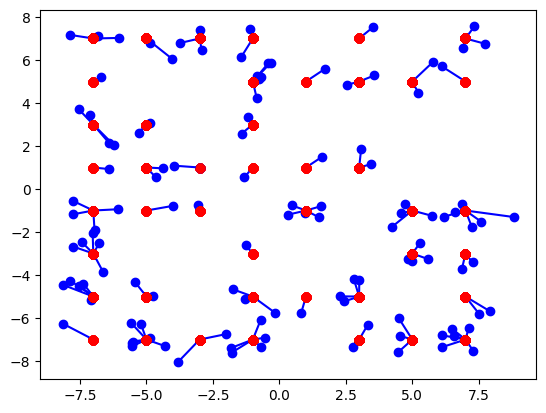

In [19]:
PS_est, hardDecision = Demapping(QAM_est, mapping_table)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
    
if save_fig:
    plt.savefig("results/Received_constellation.png")
plt.show()

In the diagram above, the blue points are the received QAM points, where as the the red points connected to them are the closest possible constellation points, and the bit groups corresponding to these red points are returned. 

Then, the bit groups need to be converted to a serial stream of bits, by means of parallel to serial conversion.

Finally, we can calculate the bit error rate

In [20]:
bits_est = P2S(PS_est)
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.025210084033613446


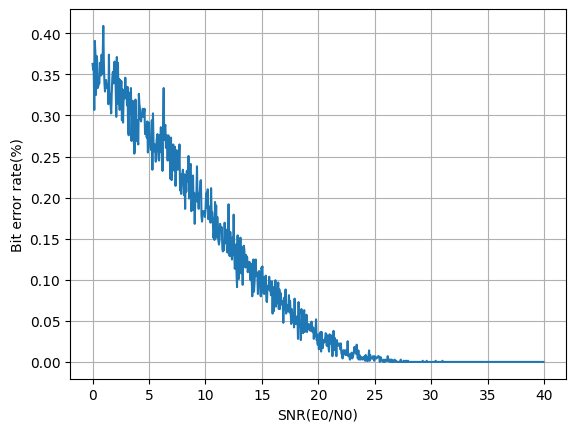

In [21]:
SNR_fp, ber_fp = SNR_return(40)
plt.plot(SNR_fp, ber_fp)
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
if save_fig:
    plt.savefig("results/ber.png")
plt.show()

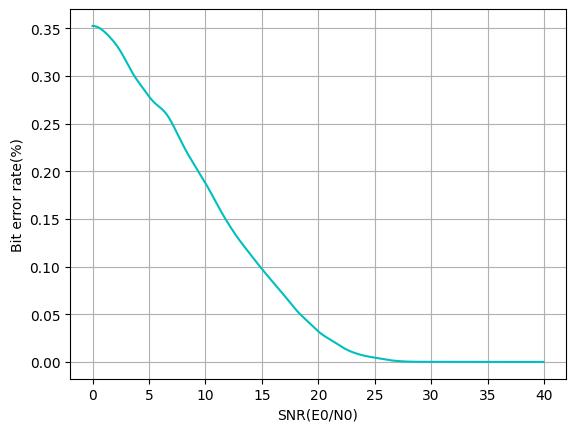

In [22]:
ysmoothed = gaussian_filter1d(ber_fp, sigma=15)
plt.plot(SNR_fp, ysmoothed, 'c')
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
plt.show()

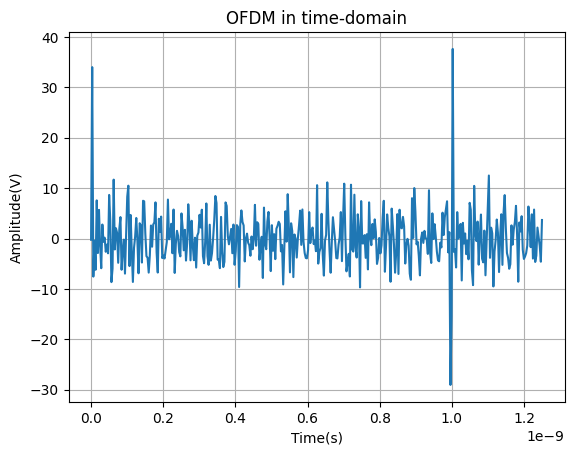

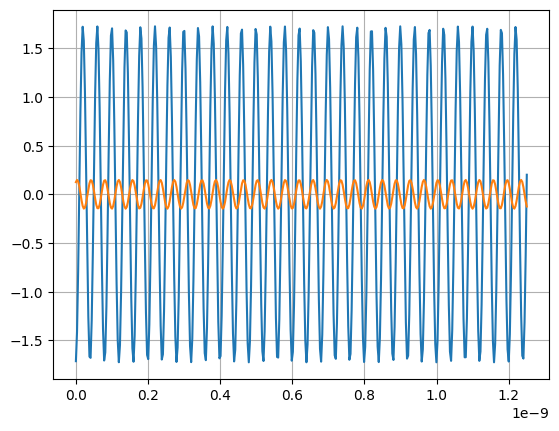

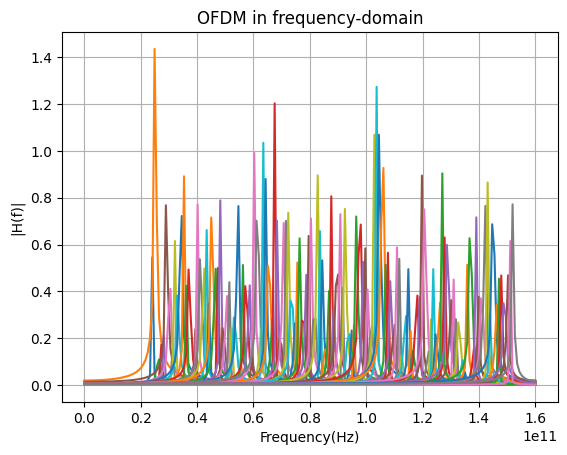

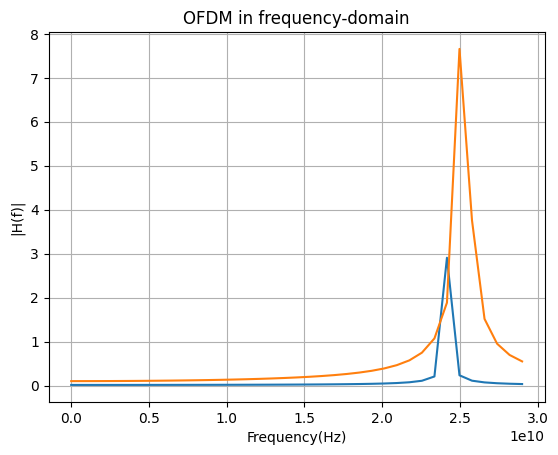

In [23]:
# The expression of wave in time domain & frequency domain
bit_x = 2
a = 1
b = 3

sin_time = []
#import math as math
# Number of sample points
N = 400
# sample spacing
T = 1 / 0.32e12
t = np.linspace(0.0, N*T, N)
fd = 0
fc = 24e9
s = np.zeros(len(t), dtype = float)
bits_SP = S2P(bits_groups[bit_x], len(dataCarriers), mu)
QAM = Mapping(bits_SP, mapping_table)
OFDM_data = OFDM_symbol(QAM, dataCarriers, pilotCarriers, pilotValue)
OFDM_time_V = IDFT(OFDM_data)
for i in OFDM_time_V:
    sin_time.append(abs(i)*np.sin(((2*np.pi)*(fc+fd)*t) + math.atan(i.imag/i.real)))
    fd += 1e9
for j in range(len(t)):
    for i in sin_time:
        s[j] += i[j]
plt.plot(t,s)
plt.grid(True)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(V)")
plt.title("OFDM in time-domain")
if save_fig:
    plt.savefig("results/time_domain_1.png")
plt.show()

#part2
for i in range(a,b):
    plt.plot(t, sin_time[i])
    plt.grid(True)
if save_fig:
    plt.savefig("results/time_domain_2.png")
plt.show()

#part3
for i in range(len(sin_time)):
    yf = scipy.fftpack.fft(sin_time[i])
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.grid(True)
plt.title("OFDM in frequency-domain")
plt.ylabel("|H(f)|")
plt.xlabel("Frequency(Hz)")
if save_fig:
    plt.savefig("results/freq_domain_1.png")
plt.show()


#look closely in 2 frequncies spiked
# Number of sample points
sin_time_x = []
G = 75 #N
# sample spacing
M = 1 / 0.0580e12 #T
O = np.linspace(0.0, G*M, G) #t
fd = 0
fc = 24e9
s = np.zeros(len(O), dtype = float)
for i in OFDM_time_V:
    sin_time_x.append(abs(i)*np.sin(((2*np.pi)*(fc+fd)*O) + math.atan(i.imag/i.real)))
    fd += 1e9
for i in range(len(sin_time[0:2])):
    yf = scipy.fftpack.fft(sin_time[i])
    xf = np.linspace(0.0, 1.0/(2.0*M), int(G/2))
    plt.plot(xf, 2.0/G * np.abs(yf[:G//2]))
plt.grid(True)
plt.title("OFDM in frequency-domain")
plt.ylabel("|H(f)|")
plt.xlabel("Frequency(Hz)")
if save_fig:
    plt.savefig("results/freq_domain_2.png")
plt.show()

### Receiver Part

In [24]:
ber = 0
bit_rx = []
SNRdb = 1
for bits_group in bits_groups:
    bits_SP = S2P(bits_group, len(dataCarriers), mu)
    QAM = Mapping(bits_SP, mapping_table)
    OFDM_data = OFDM_symbol(QAM, dataCarriers, pilotCarriers, pilotValue)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time, CP)
    OFDM_Tx = OFDM_withCP
    OFDM_Rx = channel_X(OFDM_withCP)
    OFDM_RX_noCP = OFDM_Rx[(CP):(CP+K)]
    OFDM_demod = DFT(OFDM_RX_noCP)
    Hest = channelEstimate_FIXED(OFDM_demod)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est = get_payload(equalized_Hest, dataCarriers)
    PS_est, hardDecision = Demapping(QAM_est, mapping_table)
    bits_est = PS_FIXED(PS_est)
    ber += np.sum(abs(bits_group-bits_est))/len(bits_group)
    bit_rx.append(bits_est)
print("Total BER is :" + str(ber / ((len(img_bits_tx)//payloadBits_per_OFDM)+1)))
print("All frames are sent")

Total BER is :0.02777215210944127
All frames are sent


In [25]:
bit_rx = np.array(bit_rx)
img_fr = []
img_rfr = []
for i in bit_rx:
  img_fr.append(split(i))
img_fr = np.vstack(img_fr)

img_rfr = []
for i in img_fr:
    for j in range(len(img_fr[:2][1])):
        img_rfr.append(int(i[j]))
img_rfr = np.array(img_rfr)

img_rfr1 = []
for i in range(len(img_bits_tx)):
    x = img_rfr[i]
    img_rfr1.append(x)
img_rfr1 = np.array(img_rfr1)

img_rea = []
k = 0
for i in range(len(img_rfr1)):
    img_rea.append(img_rfr1[k:k+11])
    k+=11
    
img_done = []
for i in img_rea[:]:
    x = []
    for j in range(len(i)):
        x.append(str(i[j]))
    img_done.append(x)

sep = ''
img_fin = []
for i in img_done:
    img_fin.append(sep.join(i))

In [26]:
#remove CRC and compare
img_crc = [decodeData(i, key) for i in img_fin]

count = 0
for i in img_crc:
    if i != '000':
        if i!= '00':
            count += 1

print("Amount of total bits: %10d" %(len(img_bits_tx)))
print("Amount of error bit(s): %4d" %count)

In [ ]:
#decode
img_dec = np.array([i[0:8] for i in img_fin])

In [ ]:
img_back = np.array([int(img_dec[i],2) for i in range(len(img_bytes))])
img_back = img_back.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(img_back)
if save_fig:
    plt.savefig("results/output.png")
plt.show()